In [19]:
# !pip3 install transformers
# !pip3 install git+https://github.com/gmihaila/ml_things

In [20]:
import torch
torch.cuda.empty_cache()

# Read data

In [21]:
import pandas as pd

In [22]:
df = pd.read_csv('./data/bbc-text.csv')
# df = pd.read_csv('./data/bbc-text-small.csv') # smaller dataset to save training time.

In [23]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [24]:
df.text.apply(len)

0       4333
1       1842
2       1342
3       2176
4       1579
        ... 
2220    1745
2221     955
2222    1648
2223    4684
2224    1167
Name: text, Length: 2225, dtype: int64

<AxesSubplot:xlabel='category'>

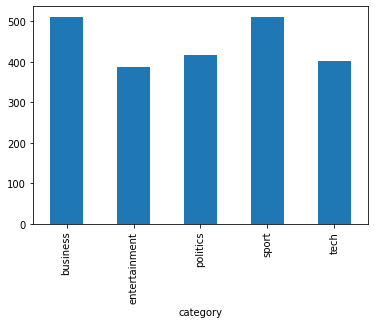

In [25]:
df.groupby("category").size().plot.bar()

# Preprocessing data

In [26]:
from transformers import GPT2Tokenizer

In [27]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

In [28]:
example_text = "I will watch Memento tonight"
gpt2_input = tokenizer(example_text, padding="max_length", max_length=10, truncation=True, return_tensors="pt")

In [29]:
print(gpt2_input['input_ids'])

tensor([[50256, 50256, 50256,    40,   481,  2342,   337,   972,    78,  9975]])


In [30]:
print(gpt2_input["attention_mask"])

tensor([[0, 0, 0, 1, 1, 1, 1, 1, 1, 1]])


In [31]:
example_text = tokenizer.decode(gpt2_input.input_ids[0])
print(example_text)

<|endoftext|><|endoftext|><|endoftext|>I will watch Memento tonight


# Dataset class

In [32]:
import torch
import numpy as np
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
labels = {
    "business": 0,
    "entertainment": 1,
    "sport": 2,
    "tech": 3,
    "politics": 4
         }

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df['text']]
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        # Get a batch of labels
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        # Get a batch of inputs
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

# Split training-test dataset

In [33]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=35),
                                     [int(0.8*len(df)), int(0.9*len(df))])

print(len(df_train), len(df_val), len(df_test))

1780 222 223


# Model building

In [34]:
from torch import nn
from transformers import GPT2Model

class SimpleGPT2SequenceClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(SimpleGPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)

        
    def forward(self, input_id, mask):
        """
        Args:
                input_id: encoded inputs ids of sent.
        """
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

# Training loop

In [35]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)
            
            model.zero_grad()

            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)
                
                output = model(input_id, mask)
                
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()
                
                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc
                
            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")
            
EPOCHS = 1
model = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128, gpt_model_name="gpt2")
LR = 1e-5

train(model, df_train, df_val, LR, EPOCHS)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 890/890 [00:49<00:00, 17.98it/s]


Epochs: 1 | Train Loss:  0.197             | Train Accuracy:  0.871             | Val Loss:  0.046             | Val Accuracy:  0.968


In [48]:
# save trained model
# torch.save(model.state_dict(), "./model/gpt2-text-classifier-model.pt")

In [37]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

        
    # Tracking variables
    predictions_labels = []
    true_labels = []
    
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            # add original labels
            true_labels += test_label.cpu().numpy().flatten().tolist()
            # get predicitons to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels
    
true_labels, pred_labels = evaluate(model, df_test)

Test Accuracy:  0.955


Normalized confusion matrix


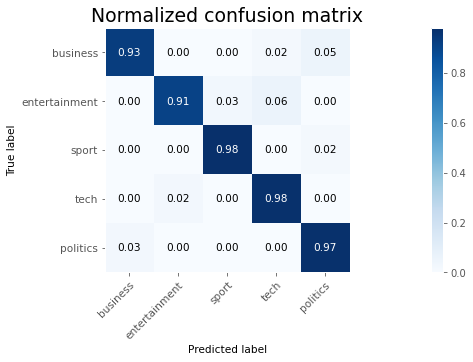

In [38]:
from ml_things import plot_confusion_matrix

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=pred_labels, 
                      classes=list(labels.keys()), normalize=True, 
                      magnify=0.1,
                      );

In [133]:
# torch.cuda.empty_cache()

# Model Inference

In [50]:
# load trained model
model_new = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128, gpt_model_name="gpt2")
model_new.load_state_dict(torch.load("./model/gpt2-text-classifier-model.pt"))
model_new.eval()

<bound method Module.eval of SimpleGPT2SequenceClassifier(
  (gpt2model): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): 

In [63]:
example_text = """
The UK has accused President Putin of plotting to install a pro-Moscow figure to lead Ukraine's government.

The Foreign Office took the unusual step of naming former Ukrainian MP Yevhen Murayev as a potential Kremlin candidate.

Russia has moved 100,000 troops near to its border with Ukraine but denies it is planning an invasion.

UK ministers have warned that the Russian government will face serious consequences if there is an incursion.

In a statement, Foreign Secretary Liz Truss said: "The information being released today shines a light on the extent of Russian activity designed to subvert Ukraine, and is an insight into Kremlin thinking.

"Russia must de-escalate, end its campaigns of aggression and disinformation, and pursue a path of diplomacy."

The Russian Ministry of Foreign Affairs tweeted that the Foreign Office was "circulating disinformation" and urged it to "cease these provocative activities" and "stop spreading nonsense".

"""
fixed_text = " ".join(example_text.lower().split())
print(fixed_text)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

model_input = tokenizer(fixed_text, padding='max_length', max_length=128, truncation=True, return_tensors="pt")

the uk has accused president putin of plotting to install a pro-moscow figure to lead ukraine's government. the foreign office took the unusual step of naming former ukrainian mp yevhen murayev as a potential kremlin candidate. russia has moved 100,000 troops near to its border with ukraine but denies it is planning an invasion. uk ministers have warned that the russian government will face serious consequences if there is an incursion. in a statement, foreign secretary liz truss said: "the information being released today shines a light on the extent of russian activity designed to subvert ukraine, and is an insight into kremlin thinking. "russia must de-escalate, end its campaigns of aggression and disinformation, and pursue a path of diplomacy." the russian ministry of foreign affairs tweeted that the foreign office was "circulating disinformation" and urged it to "cease these provocative activities" and "stop spreading nonsense".


In [64]:
mask = model_input['attention_mask'].cpu()
input_id = model_input["input_ids"].squeeze(1).cpu()

output = model_new(input_id, mask)

In [65]:
print(output)

tensor([[-0.4280, -3.0708,  0.4508, -1.4243,  6.4141]],
       grad_fn=<AddmmBackward0>)


In [66]:
labels_map = {
    0: "business",
    1: "entertainment",
    2: "sport",
    3: "tech",
    4: "politics"
         }

pred_label = labels_map[output.argmax(dim=1).item()]
print(pred_label)

politics
